In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import Setup as p
import Corrfunc
import Likelihood
from matplotlib.colors import LogNorm

model = Likelihood.MasterEquation()

catalog = model.abundance_match(0.5, 0.16, 1)

In [55]:
x = catalog[0]['x']
y = catalog[0]['y']
z = catalog[0]['z']
length = 400
IDS1 = np.where(x < length)
IDS2 = np.where(y < length)
IDS3 = np.where(z < length)
IDS = np.intersect1d(IDS1, IDS2)
IDS = np.intersect1d(IDS, IDS3)

cat = {'x' : x[IDS], 'y' : y[IDS], 'z' : z[IDS]}

In [56]:
for i in range(10, 400):
    if 400 % i == 0:
#         print(i, end=', ')
        print(i, (400/i)**2, end='; ')
        

10 1600.0; 16 625.0; 20 400.0; 25 256.0; 40 100.0; 50 64.0; 80 25.0; 100 16.0; 200 4.0; 

In [57]:
subsides = [16, 20, 25, 40, 50, 80, 100, 200]
rp_bins = np.logspace(np.log10(p.min_rp), np.log10(p.max_rp), p.nbins+1)
covmats = list()
mean_wps = list()
stds = list()
boxsize = length

# subsides = subsides[3:]

for subside in subsides:
    nside = int(boxsize/subside)
    edges = np.arange(0, boxsize+subside, subside)
    lx = np.digitize(cat['x'], edges)-1
    ly = np.digitize(cat['y'], edges)-1
    nboxes = edges.size-1
    gbins = ly*nboxes+lx
    wp_out = list()
    
    
    Nsub = nside**2
    for i in range(Nsub):
        IDS = np.where(gbins != i)
        XX = cat['x'][IDS]
        YY = cat['y'][IDS]
        ZZ = cat['z'][IDS]
        wp = Corrfunc.theory.wp(boxsize=boxsize, pimax=p.pimax,
                                nthreads=p.nthreads, binfile=rp_bins, X=XX, Y=YY, Z=ZZ)
        wp_out.append(wp['wp'])

    wp_out = np.array(wp_out)

    mean_wp = np.mean(wp_out, axis=0)
    cov_matrix = np.zeros((p.nbins, p.nbins))
    arr = np.arange(Nsub)
    for i in range(p.nbins):
        for j in range(p.nbins):
            for k in range(Nsub):
                IDS = np.where(arr != k)
                cmean_wp = np.mean(wp_out[IDS], axis=0)
                cov_matrix[i, j] += (wp_out[k, i]-cmean_wp[i])*(wp_out[k, j]-cmean_wp[j])

    cov_matrix = cov_matrix*(Nsub-1)/Nsub
    
    covmats.append(cov_matrix)
    mean_wps.append(mean_wp)
    stds.append(np.sqrt(np.diagonal(cov_matrix)))

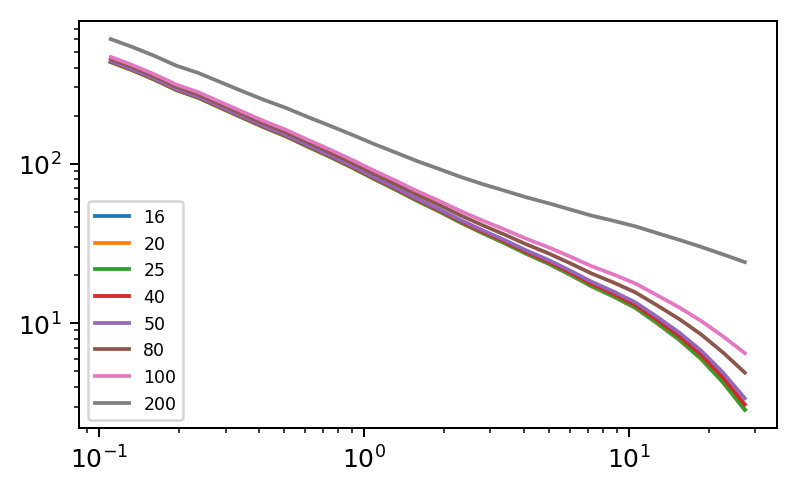

In [156]:
cvs = np.array(covmats)
x = p.bin_centers(rp_bins)
plt.figure(dpi=180, figsize=(5, 3))
for i in range(len(mean_wps)):
    plt.loglog(x, mean_wps[i], label=subsides[i])
plt.legend(fontsize='x-small')
plt.show()

In [94]:
cvs = np.array(covmats)
cvs.shape

(8, 30, 30)

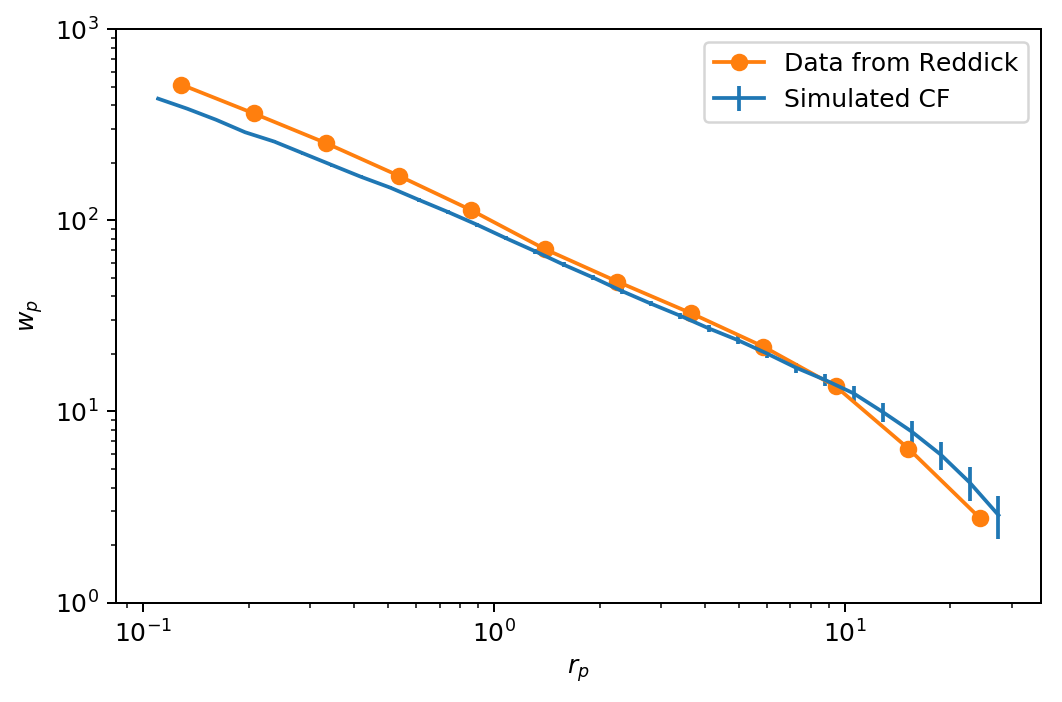

In [82]:
n= 0

fig = plt.figure(dpi=180)
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(x, mean_wps[n], yerr=stds[n], label="Simulated CF")
# ax.plot(p.xr, p.yr, label='Data from Reddick', marker='o')
ax.set_xlabel(r'$r_p$')
ax.set_ylabel(r'$w_p$')
ax.set_ylim(bottom=10**(0), top=10**(3))
ax.legend()
plt.tight_layout()
# plt.savefig("../../Plots/Corrfunc/4_CFcomparSIM.png", dpi=180)
plt.show()

In [65]:
def plotmat(cov, nbox, norm=False):
    fig = plt.figure(dpi=120, figsize=(5,5))
    ax = plt.axes()
    ax.set_title("Difference for side length = {}".format(nbox))
    if norm == False:
        Z = np.abs((cov-covmats[0])/covmats[0])
        cax = ax.matshow(Z)
    else:
        Z = np.abs((cov-covmats[0])/covmats[0])*100
        cax = ax.matshow(Z, norm=LogNorm(vmin=np.min(Z), vmax=np.max(Z)))
    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()
    plt.close()

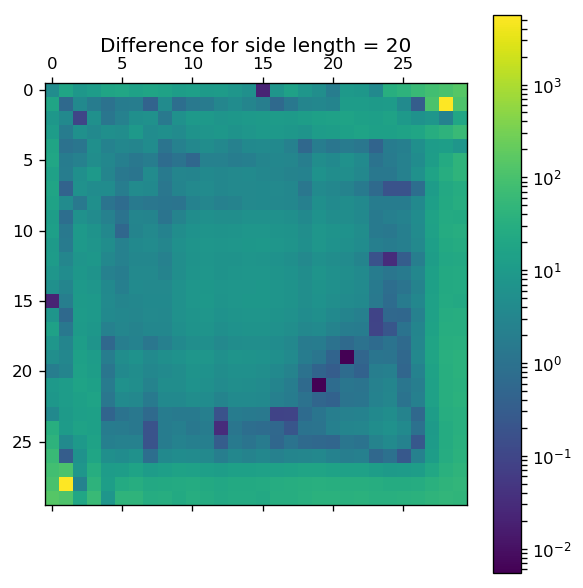

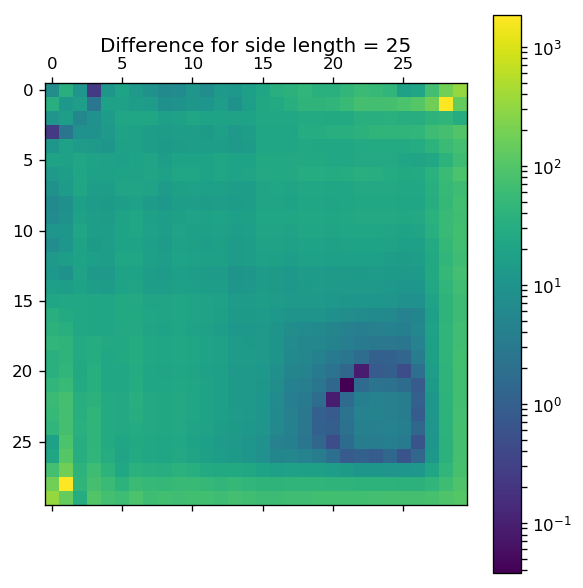

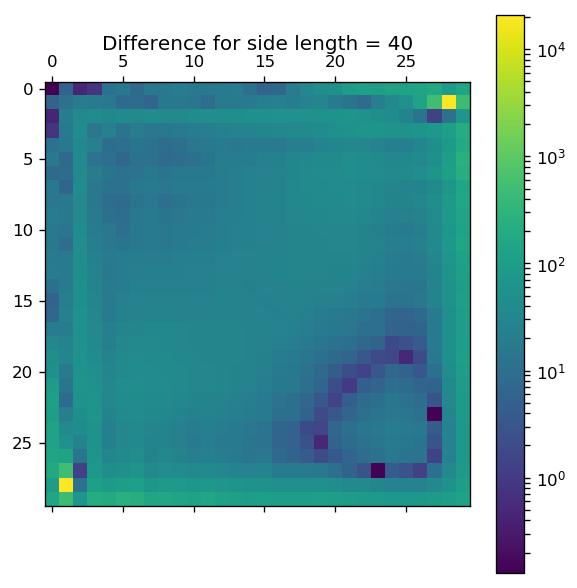

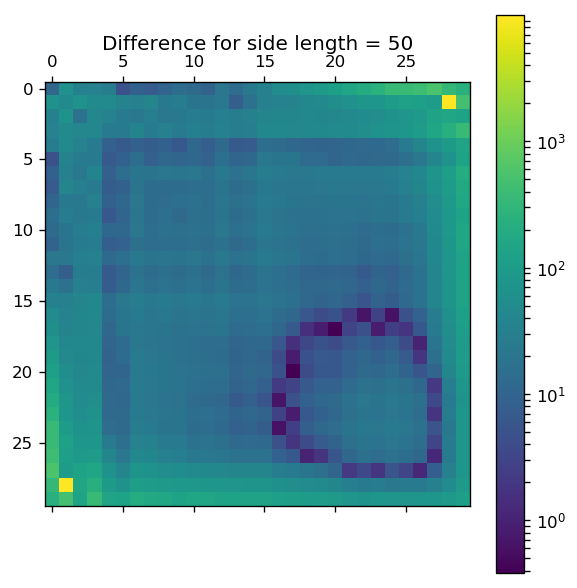

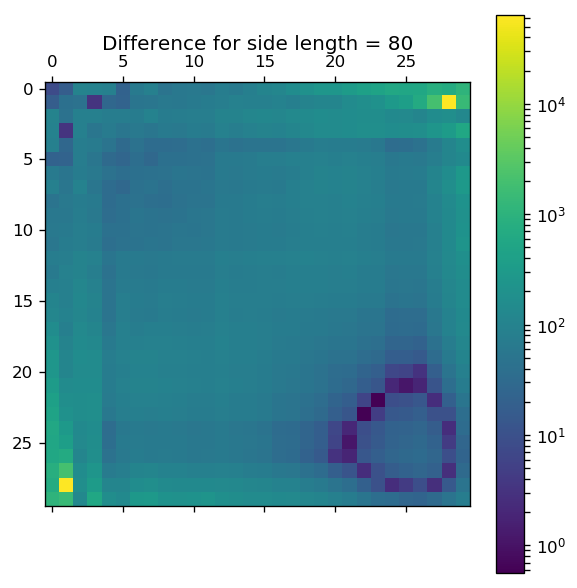

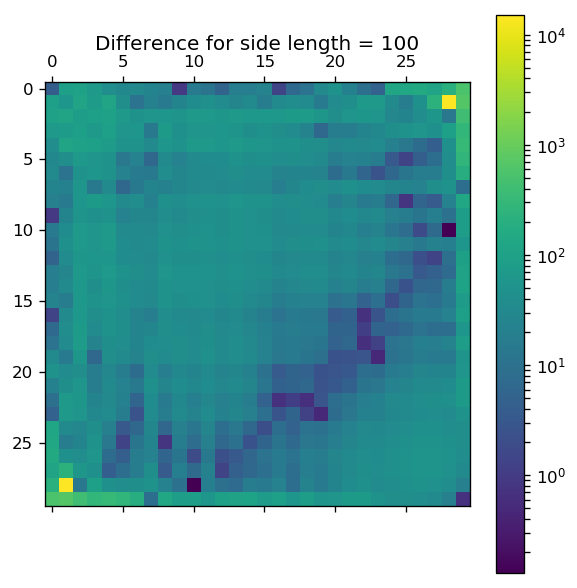

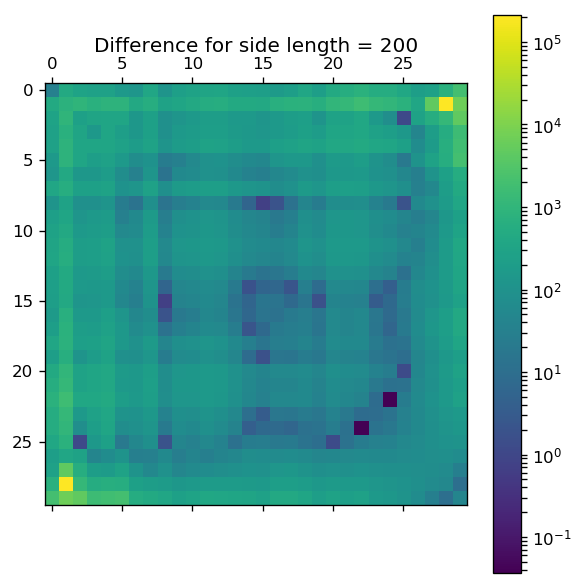

In [66]:
for i in range(1, len(mean_wps)):
    plotmat(covmats[i], subsides[i],norm=True)

## Frobenius norm

In [109]:
def frobenius_dist(mat1, mat2):
    res = 0
    ndim = mat1.shape[0]
    for i in range(ndim):
        for j in range(ndim):
            res += (mat1[i, j] - mat2[i, j])**2
    return np.sqrt(res)

In [145]:
print(subsides)
for i in range(len(subsides)):
    for j in range(i+1, len(subsides)):
        d = frobenius_dist(covmats[i], covmats[j])
        print("Side {} and {} diff = {}".format(subsides[i], subsides[j], d))

[16, 20, 25, 40, 50, 80, 100, 200]
Side 16 and 20 diff = 8.860133028800623
Side 16 and 25 diff = 22.934796680615737
Side 16 and 40 diff = 29.766017017906044
Side 16 and 50 diff = 37.90540784363593
Side 16 and 80 diff = 85.27431334917793
Side 16 and 100 diff = 73.67800944540888
Side 16 and 200 diff = 443.901682331242
Side 20 and 25 diff = 22.534544190045036
Side 20 and 40 diff = 25.95618228410019
Side 20 and 50 diff = 37.99079073510252
Side 20 and 80 diff = 83.43995820829001
Side 20 and 100 diff = 72.06523428705488
Side 20 and 200 diff = 444.08294647756736
Side 25 and 40 diff = 20.029055001425867
Side 25 and 50 diff = 23.414766750092394
Side 25 and 80 diff = 70.05806739116164
Side 25 and 100 diff = 58.755337332453
Side 25 and 200 diff = 429.49435164985704
Side 40 and 50 diff = 28.576392491695835
Side 40 and 80 diff = 62.09549740706968
Side 40 and 100 diff = 55.20143577493974
Side 40 and 200 diff = 431.9898051274686
Side 50 and 80 diff = 66.70696305783083
Side 50 and 100 diff = 47.036350